- https://paeton.tistory.com/entry/Window-Function%EC%9D%84-%EC%93%B0%EB%8A%94-%EC%9D%B4%EC%9C%A0

### STFT (Short-Time Fourier Transform)

FFT는 시간에 흐름에 따라 신호의 수파수가 변했을때, 어느 시간대에 주파수가 변하는지 모르게 됩니다. 이러한 한계를 극복하기 위해서, STFT는 시간의 길이를 나눠서 이제 퓨리에 변환을 하게 됩니다. 즉 FFT를 했을때는 Time domina에 대한 정보가 날아가게 되는 것이죠.

주파수의 특성이 시간에 따라 달라지는 사운드를 분석하는 방법입니다. 일반적으로 우리가 사용하는 signal 데이터에 적합하다. 시계열 데이터를 일정한 시간 구간 (window size)로 나누고, 각 구간에 대해서 스펙트럼을 구하는 데이터이다. 이는 Time-frequency 2차원 데이터로 표현이 됩니다.

$$
X(l,k) = \sum_{n=0}^{N-1} w(n) x(n+lH)\exp^{\frac{-2\pi k n}{N}}
$$

- $N$ : FFT size
    - Window를 얼마나 많은 주파수 밴드로 나누는가 입니다.

- Duration
    - 샘플링 레이트를 window로 나눈 값입니다.
    - $T= window/SR$
    - T(Window) = 5T(Signal), duration은 신호주기보다 5배 이상 길게 잡아야한다.
    - 440Hz 신호의 window size는 5*(1/440)이 됩니다.

- $w(n)$ : Window function
    - 일반적으로 Hann window가 쓰입니다.

- $n$ : Window size
    - Window 함수에 들어가는 Sample의 양입니다.
    - 작을수록 Low-frequency resolution을 가지게 되고, high-time resolution을 가집니다.
    - 길수록 High-frequency, low time resolution을 가집니다.
    
- $H$ : Hop size
    - 윈도우가 겹치는 사이즈입니다. 일반적으로는 1/4정도를 겹치게 합니다.

STFT의 결과는 즉 시간의 흐름(Window)에 따른 Frequency영역별 Amplitude를 반환합니다.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
%matplotlib inline
import librosa
train_audio_path = 'input/train/audio'
filename = '/yes/ffd2ba2f_nohash_0.wav'
samples, sample_rate = librosa.load(str(train_audio_path)+filename)

위 스펙트럼은 44 Hz의 폭으로 513개의 bin으로 분할되어 있습니다.

여기서 실수부를 제거하면서 magnitude에 대한 데이터만 받아와봅시다.

In [4]:
# STFT
S = librosa.core.stft(samples, n_fft=1024, hop_length=512, win_length=1024)

In [5]:
S.shape, len(S[0]), S[0][0]

((513, 44), 44, (-0.2504628+0j))

In [6]:
sample_rate/512

43.06640625

In [7]:
# phase 에 대한 정보를 날린다.
D = np.abs(S)**2

In [8]:
D.shape

(513, 44)

### Window function?

위에서 Window function과 Window size라는 이야기가 나오고 있습니다. 윈도우 Function과 Size는 왜 쓰는 것이며 어떨때 쓰는 것일까요?

Window function의 주된 기능은 main-lobe의 width와 side-lobe의 레벨의 Trade-off 를 제어해 준다는 장점이 있습니다. 그리고 깁스 현상을 막아주는 고마운 친구이기도 하죠. 지금나온 main-lobe, side-bloe, 깁스현상은 무엇일까요?

<img src="./img/window.png" width=70%>




In [10]:
def frame_audio(audio, FFT_size=1024, hop_size=20, sample_rate = 22050):
    audio = np.pad(audio, int(FFT_size/2), mode='reflect')
    frame_len = np.round(sample_rate*hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num, FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    return frames

In [12]:
audio_framed = frame_audio(samples)
print("Framed audio shape: {}".format(audio_framed.shape))

Framed audio shape: (51, 1024)


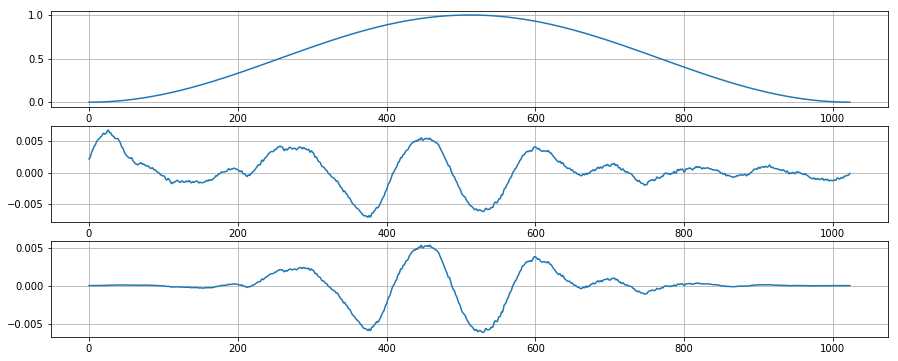

In [30]:
from scipy import signal

window = signal.get_window("hann", 1024, fftbins=True)
audio_win = audio_framed * window
ind = 2
plt.figure(figsize=(15,6))
plt.subplot(3,1,1)
plt.plot(window)
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(audio_framed[ind])
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(audio_win[ind])
plt.grid(True)
plt.show()

플롯을 보게 된다면 windowing을 적용하기전 plot은 끝부분이 다 다르지만, windowing을 지나고 나서 나오는 plot은 끝이 0 으로 일치한다는 특성을 볼 수 있습니다.

### Window size?

윈도우 사이즈는 일반적으로 time과 frequency의 resolutions을 제어해 줍니다.
- short-window : 낮은 frequency resolution, 높은 time-resolution을 가지게 됩니다.
- Long-window : 높은 frequency resolution을 가지며, 낮은 time-resolution을 가지게 됩니다.